## NEW YORK AIRBNB DATA ANALYSIS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

In [28]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style('white')

In [2]:
df = pd.read_csv('AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
# Let's have a look at all columns and understand its importance.
df.columns

# Name, Host_Name wouldn't have much effect on our model. So will discard them later.

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [5]:
# Let's look at the type of all variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [6]:
# We can see there are quite a few missing values.
# Let's check them out and decide a plan to deal with them later - 

df.isnull().sum()

# Last_review and Reviews_per_month have more missing values - 100052.

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

 
In our case, 'last_review' is a date. Doesn't make sense to fill up this column with any sort of values.

It is best to drop it. Also, for 'Reviews per month' we can simply impute with 0.0 values.

In [8]:
df.drop(['id', 'host_name', 'last_review'], axis = 1, inplace = True)
df.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [11]:
# Now,let's deal with 'Reviews per month' column and impute missing values
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [12]:
df['reviews_per_month'].isnull().sum()

0

In [14]:
# Let's now consider our categorical variables. It is very crucial for us to understand its importance in our data &
# we need a thorough interpretation of the same.
# Starting with the neighbourhood region.

df['neighbourhood_group'].nunique()

5

In [15]:
df['neighbourhood_group'].value_counts()

# We have 5 main neighbourhood groups in NYC.

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

In [16]:
# Also, lets see our neighbourhood regions in NYC.

df['neighbourhood'].nunique()

221

In [17]:
# And our room category as well.

df['room_type'].nunique()

3

In [18]:
df['room_type'].value_counts()

# Three main types of accommodation we have.

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

#### EXPLORING AND VISUALIZING OUR DATA

In [22]:
# Let's look at most popular host ids - 

host_code = df['host_id'].value_counts().head()
host_code

219517861    327
107434423    232
30283594     121
137358866    103
12243051      96
Name: host_id, dtype: int64

In [27]:
# We already have a column as calculated host listings - 

host_check = df['calculated_host_listings_count'].max()
host_check

327

In [49]:
host_code_df = pd.DataFrame(host_code)
host_code_df.reset_index(inplace = True)
host_code_df.rename(columns = {'index': 'Host_ID', 'host_id':'Total_Count'}, inplace = True)
host_code_df

,Host_ID,Total_Count
0,219517861,327
1,107434423,232
2,30283594,121
3,137358866,103
4,12243051,96


Text(0.5, 1.0, 'Most Popular listings in NYC')

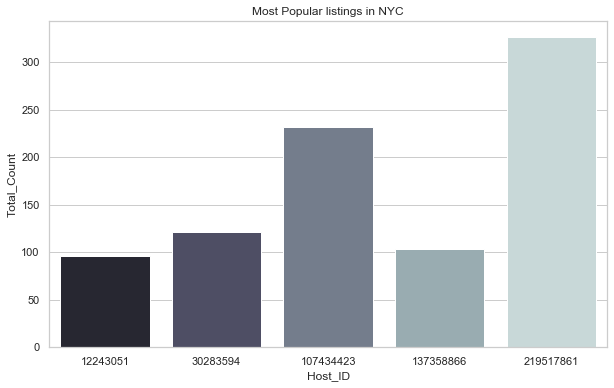

In [56]:
# We will plot this out for better visualization

sns.set_style('whitegrid')
sns.barplot(x = host_code_df['Host_ID'], y = host_code_df['Total_Count'], palette = 'bone',
            data = host_code_df)
plt.title('Most Popular listings in NYC')

In [66]:
# Let's have a look at our 5 main neighbourhood regions - 

# Brooklyn
neigh_1 = df.loc[df['neighbourhood_group'] == 'Brooklyn']
neigh_price1 = neigh_1[['price']]

# Manhattan
neigh_2 = df.loc[df['neighbourhood_group'] == 'Manhattan']
neigh_price2 = neigh_2[['price']]

# Queens
neigh_3 = df.loc[df['neighbourhood_group'] == 'Queens']
neigh_price3 = neigh_3[['price']]

# Staten Island
neigh_4 = df.loc[df['neighbourhood_group'] == 'Staten Island']
neigh_price4 = neigh_4[['price']]

# Bronx
neigh_5 = df.loc[df['neighbourhood_group'] == 'Bronx']
neigh_price5 = neigh_5[['price']]

price_list = [neigh_price1, neigh_price2, neigh_price3, neigh_price4, neigh_price5]

In [68]:
# Creating an empty list which we will append with statistics & neighbourhood region.
price_dist = []
neighbourhood_list = ['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx']

In [81]:
for i in price_list:
    x = i.describe(percentiles = [.25, .50, .70])
    x = x.iloc[3:]
    x.reset_index(inplace = True)
    x.rename(columns = {'index':'Stats'}, inplace = True)
    price_dist.append(x)

In [90]:
price_dist[0].rename(columns = {'price':neighbourhood_list[0]}, inplace = True)
price_dist[1].rename(columns = {'price':neighbourhood_list[1]}, inplace = True)
price_dist[2].rename(columns = {'price':neighbourhood_list[2]}, inplace = True)
price_dist[3].rename(columns = {'price':neighbourhood_list[3]}, inplace = True)
price_dist[4].rename(columns = {'price':neighbourhood_list[4]}, inplace = True)

In [102]:
stats_df = price_dist
stats_df = [df.set_index('Stats') for df in stats_df]
stats_df = stats_df[0].join(stats_df[1:])
stats_df.style.background_gradient(cmap = 'Reds')

,Brooklyn,Manhattan,Queens,Staten Island,Bronx
Stats,,,,,
min,0.000000,0.000000,10.000000,13.000000,0.000000
25%,60.000000,95.000000,50.000000,50.000000,45.000000
50%,90.000000,150.000000,75.000000,75.000000,65.000000
70%,130.000000,200.000000,100.000000,100.000000,87.000000
max,10000.000000,10000.000000,10000.000000,5000.000000,2500.000000


In [108]:
# From the above table, we can see there are quite a few extreme values and can be called as 'outliers'.
# We need to discard them for better visualization.

new_df = df[df.price < 500]
new_df

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Charming one bedroom - newly renovated rowhouse,8232441,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,0.00,2,9
48891,Affordable room in Bushwick/East Williamsburg,6570630,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,0.00,2,36
48892,Sunny Studio at Historical Neighborhood,23492952,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,0.00,1,27
48893,43rd St. Time Square-cozy single bed,30985759,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,0.00,6,2


Text(0.5, 1.0, 'Distribution of Price across Neighbourhood Regions')

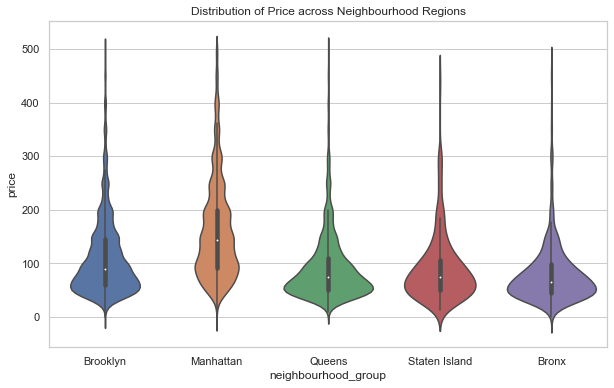

In [110]:
sns.set_style('whitegrid')
sns.violinplot(x = new_df['neighbourhood_group'], y = new_df['price'], data = new_df)
plt.title('Distribution of Price across Neighbourhood Regions')

In [111]:
# We can see Manhattan has the highest price with an average of $150.
# Followed by Brooklyn approx $90.
# Queens and Bronx have similar distribution.
# Bronx being the cheapest.

In [114]:
df['neighbourhood'].value_counts().head(10)

Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Hell's Kitchen        1958
East Village          1853
Upper East Side       1798
Crown Heights         1564
Midtown               1545
Name: neighbourhood, dtype: int64

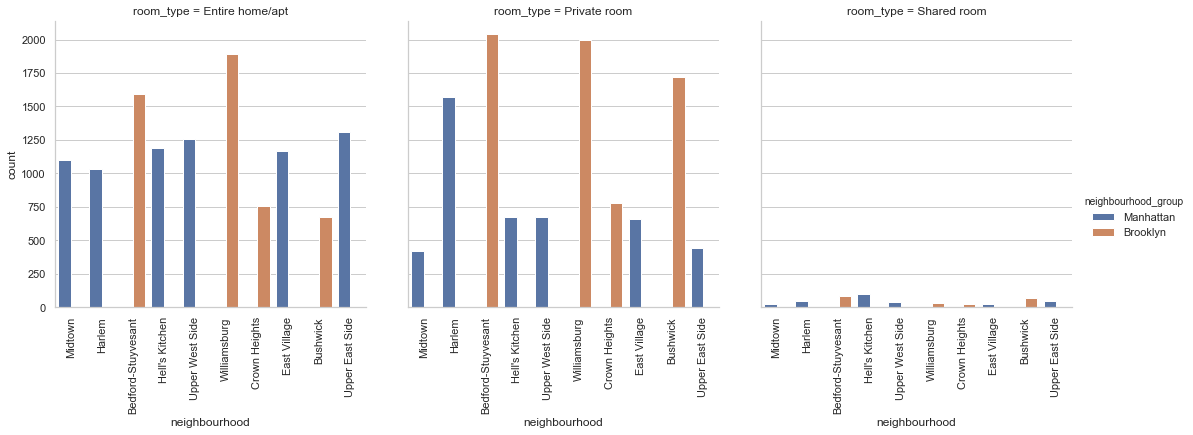

In [117]:
sub_data = df.loc[df['neighbourhood'].isin(['Williamsburg', 'Bedford-Stuyvesant', 'Harlem', 
                                           'Bushwick', 'Upper West Side', 'Hell\'s Kitchen', 'East Village',
                                           'Upper East Side', 'Crown Heights', 'Midtown'])]
sns.set_style('whitegrid')
plot = sns.catplot(x = 'neighbourhood', hue = 'neighbourhood_group',
           col= 'room_type', data = sub_data, kind = 'count')
plot.set_xticklabels(rotation = 90)

In [118]:
# Seems to me like private room has more popularity, since tourists from all over the word will likely opt to stay in a
# cozy comfortable room.
# Bedford-Stuyvesant and Williamsburg have the highest popularity.
# The importance of shared room is very less, as seen in the above chart.
# Also, we can see there are only two neighbourhood regions - Manhattan and Brooklym.
# Considering the popularity & tourist attractions, these 2 regions hold more value compared to others.

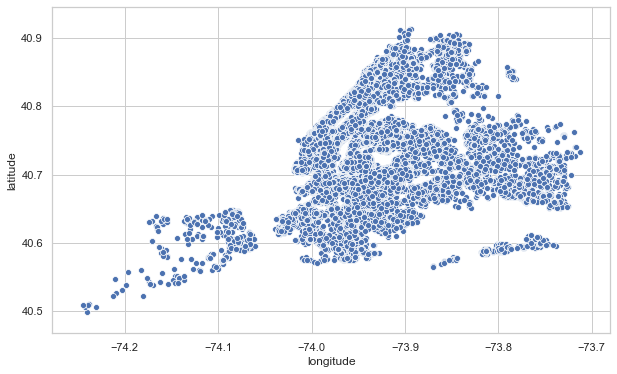

In [127]:
sns.scatterplot(x = df['longitude'], y = df['latitude'], cmap = plt.get_cmap('jet'), data = df)

# This is basic representation of NYC using longitude & latitude.
# Let's see how we can visualize this even better.

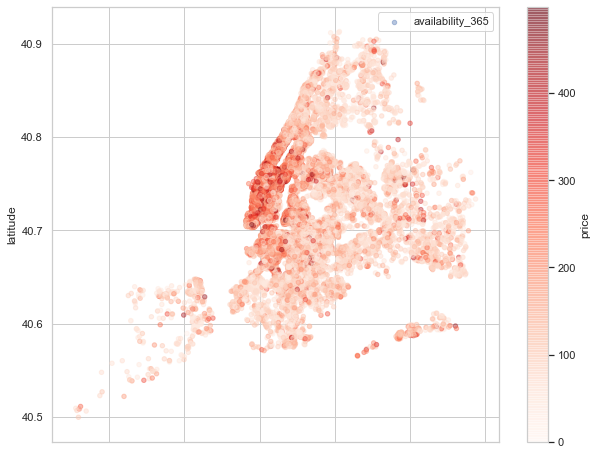

In [132]:
plot_nyc = new_df.plot(kind='scatter', x='longitude', y='latitude', label='availability_365', c='price',
                  cmap=plt.get_cmap('Reds'), colorbar=True, alpha=0.4, figsize=(10,8))
plot_nyc.legend()

In [133]:
df['name']

0                       Clean & quiet apt home by the park
1                                    Skylit Midtown Castle
2                      THE VILLAGE OF HARLEM....NEW YORK !
3                          Cozy Entire Floor of Brownstone
4         Entire Apt: Spacious Studio/Loft by central park
                               ...                        
48890      Charming one bedroom - newly renovated rowhouse
48891        Affordable room in Bushwick/East Williamsburg
48892              Sunny Studio at Historical Neighborhood
48893                 43rd St. Time Square-cozy single bed
48894    Trendy duplex in the very heart of Hell's Kitchen
Name: name, Length: 48895, dtype: object

In [134]:
names = []
for word in df['name']:
    names.append(word)

In [146]:
def splitting_name(word):
    spl = str(word).split()
    return spl

names_count = []
for x in names:
    for item in splitting_name(x):
        item = item.lower()
        names_count.append(item)

In [150]:
from collections import Counter
head_25 = Counter(names_count).most_common()
head_25 = head_25[0:25]
head_25

[('in', 16733),
 ('room', 9389),
 ('bedroom', 7231),
 ('private', 6985),
 ('apartment', 6113),
 ('cozy', 4634),
 ('the', 3869),
 ('to', 3827),
 ('studio', 3772),
 ('brooklyn', 3629),
 ('apt', 3571),
 ('spacious', 3387),
 ('1', 3357),
 ('with', 3092),
 ('2', 3079),
 ('of', 2993),
 ('east', 2967),
 ('and', 2869),
 ('manhattan', 2855),
 ('&', 2820),
 ('park', 2632),
 ('sunny', 2536),
 ('beautiful', 2320),
 ('near', 2295),
 ('williamsburg', 2293)]

In [155]:
head_data = pd.DataFrame(head_25)
head_data.rename(columns = {0:'Common_Words', 1:'Count'}, inplace = True)
head_data.head()
# Top 5 most common words.

,Common_Words,Count
0,in,16733
1,room,9389
2,bedroom,7231
3,private,6985
4,apartment,6113


[Text(0, 0, 'in'),
 Text(0, 0, 'room'),
 Text(0, 0, 'bedroom'),
 Text(0, 0, 'private'),
 Text(0, 0, 'apartment'),
 Text(0, 0, 'cozy'),
 Text(0, 0, 'the'),
 Text(0, 0, 'to'),
 Text(0, 0, 'studio'),
 Text(0, 0, 'brooklyn'),
 Text(0, 0, 'apt'),
 Text(0, 0, 'spacious'),
 Text(0, 0, '1'),
 Text(0, 0, 'with'),
 Text(0, 0, '2'),
 Text(0, 0, 'of'),
 Text(0, 0, 'east'),
 Text(0, 0, 'and'),
 Text(0, 0, 'manhattan'),
 Text(0, 0, '&'),
 Text(0, 0, 'park'),
 Text(0, 0, 'sunny'),
 Text(0, 0, 'beautiful'),
 Text(0, 0, 'near'),
 Text(0, 0, 'williamsburg')]

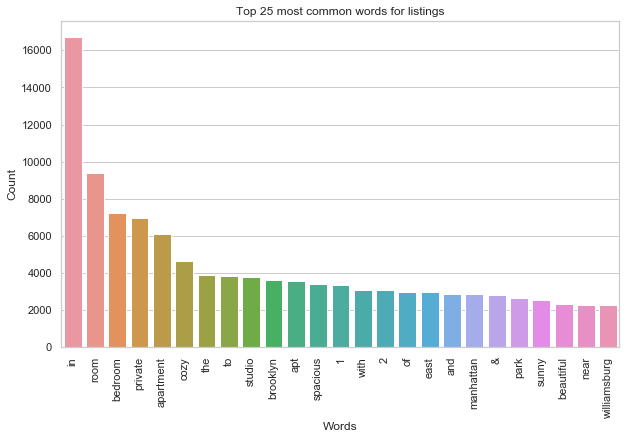

In [161]:
sns.set_style('whitegrid')
visual = sns.barplot(x = head_data['Common_Words'], y = head_data['Count'], data = head_data)
visual.set_title('Top 25 most common words for listings')
visual.set_xlabel('Words')
visual.set_xticklabels(visual.get_xticklabels(), rotation = 90)

In [162]:
most_reviews = df.nlargest(10, 'number_of_reviews')
most_reviews

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
11759,Room near JFK Queen Bed,47621202,Queens,Jamaica,40.66730,-73.76831,Private room,47,1,629,14.58,2,333
2031,Great Bedroom in Manhattan,4734398,Manhattan,Harlem,40.82085,-73.94025,Private room,49,1,607,7.75,3,293
2030,Beautiful Bedroom in Manhattan,4734398,Manhattan,Harlem,40.82124,-73.93838,Private room,49,1,597,7.72,3,342
2015,Private Bedroom in Manhattan,4734398,Manhattan,Harlem,40.82264,-73.94041,Private room,49,1,594,7.57,3,339
13495,Room Near JFK Twin Beds,47621202,Queens,Jamaica,40.66939,-73.76975,Private room,47,1,576,13.40,2,173
10623,Steps away from Laguardia airport,37312959,Queens,East Elmhurst,40.77006,-73.87683,Private room,46,1,543,11.59,5,163
1879,Manhattan Lux Loft.Like.Love.Lots.Look !,2369681,Manhattan,Lower East Side,40.71921,-73.99116,Private room,99,2,540,6.95,1,179
20403,Cozy Room Family Home LGA Airport NO CLEANING FEE,26432133,Queens,East Elmhurst,40.76335,-73.87007,Private room,48,1,510,16.22,5,341
4870,Private brownstone studio Brooklyn,12949460,Brooklyn,Park Slope,40.67926,-73.97711,Entire home/apt,160,1,488,8.14,1,269
471,LG Private Room/Family Friendly,792159,Brooklyn,Bushwick,40.70283,-73.92131,Private room,60,3,480,6.70,1,0


In [165]:
price_average = most_reviews['price'].mean()
print("Average price per night is: ", price_average)

Average price per night is:  65.4
